# CRAFTY Web Scraping. Flavio Romano, 614801

In [3]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

"""Datasets"""
transactions = pd.read_csv("./datasets/transactions.csv", names=["timestamp", "blockId", "txId", "isCoinbase", "fee"])
inputs = pd.read_csv("./datasets/inputs.csv", names=["txId", "prevTxId", "prevTxPos"])
outputs = pd.read_csv("./datasets/outputs.csv", names=["txId", "position", "addressId", "amount", "scriptType"])
mapping_df = pd.read_csv("./datasets/mapAddr2Ids8708820.csv", names=["hash", "addressId"])

transactions['timestamp'] = pd.to_datetime(transactions['timestamp'], unit='s')

## 1. Analisi generali sui dati

In [4]:
print(transactions.head())
print(inputs.head())
print(outputs.head())
print(mapping_df.head())

            timestamp  blockId  txId  isCoinbase  fee
0 2009-01-09 03:54:39        9     9           1    0
1 2009-01-11 01:00:54       78    78           1    0
2 2009-01-12 03:30:25      170   171           0    0
3 2009-01-12 06:02:13      181   183           0    0
4 2009-01-12 06:12:16      182   185           0    0
   txId  prevTxId  prevTxPos
0   171         9          0
1   183       171          1
2   185       183          1
3   187       185          1
4   192       187          0
   txId  position  addressId      amount  scriptType
0     9         0          9  5000000000           1
1    78         0         78  5000000000           1
2   171         0        171  1000000000           1
3   171         1          9  4000000000           1
4   183         0        183  1000000000           1
                                 hash  addressId
0  1A1zP1eP5QGefi2DMPTfTL5SLmv7DivfNa          0
1  12c6DSiU4Rq3P4ZxziKxzrL5LmMBrzjrJX          1
2  1HLoD9E4SDFFPDiYfNYnkBLQ85Y51J3Zb1

### I. Distribuzione del numero di transazioni per blocco (occupazione del blocco), nell’intero periodo temporale considerato

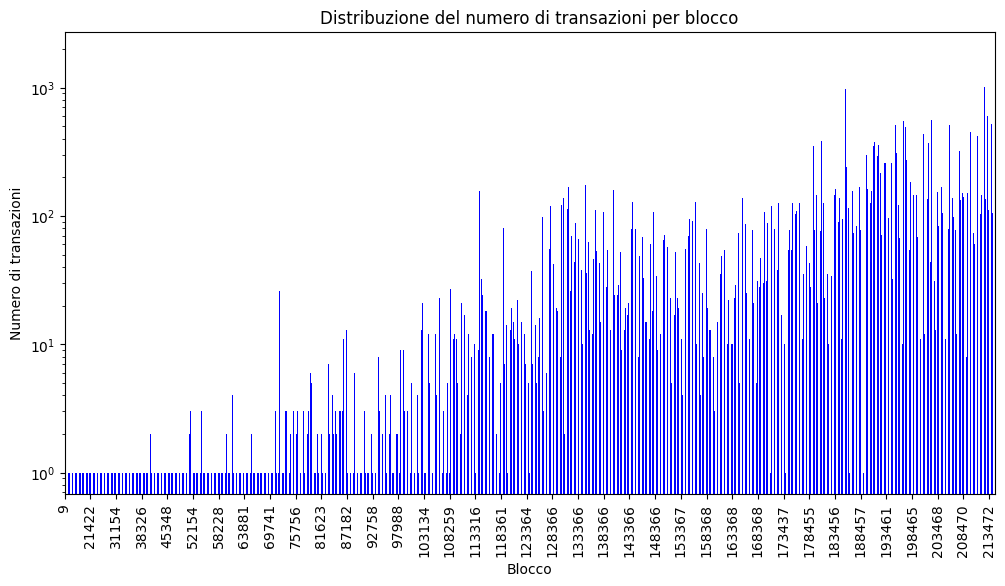

In [287]:
transactions_per_block = transactions.groupby("blockId")["txId"].count()

plt.figure(figsize=(16,9))
transactions_per_block.plot(kind="bar", color="blue")
plt.xlabel("Blocco")
plt.ylabel("Numero di transazioni")
plt.title("Distribuzione del numero di transazioni per blocco")

plt.yscale("log")

x_ticks = range(0, len(transactions_per_block), 5000)
plt.xticks(x_ticks, transactions_per_block.index[x_ticks])

plt.show()

### II. Evoluzione dell'occupazione dei blocchi nel tempo

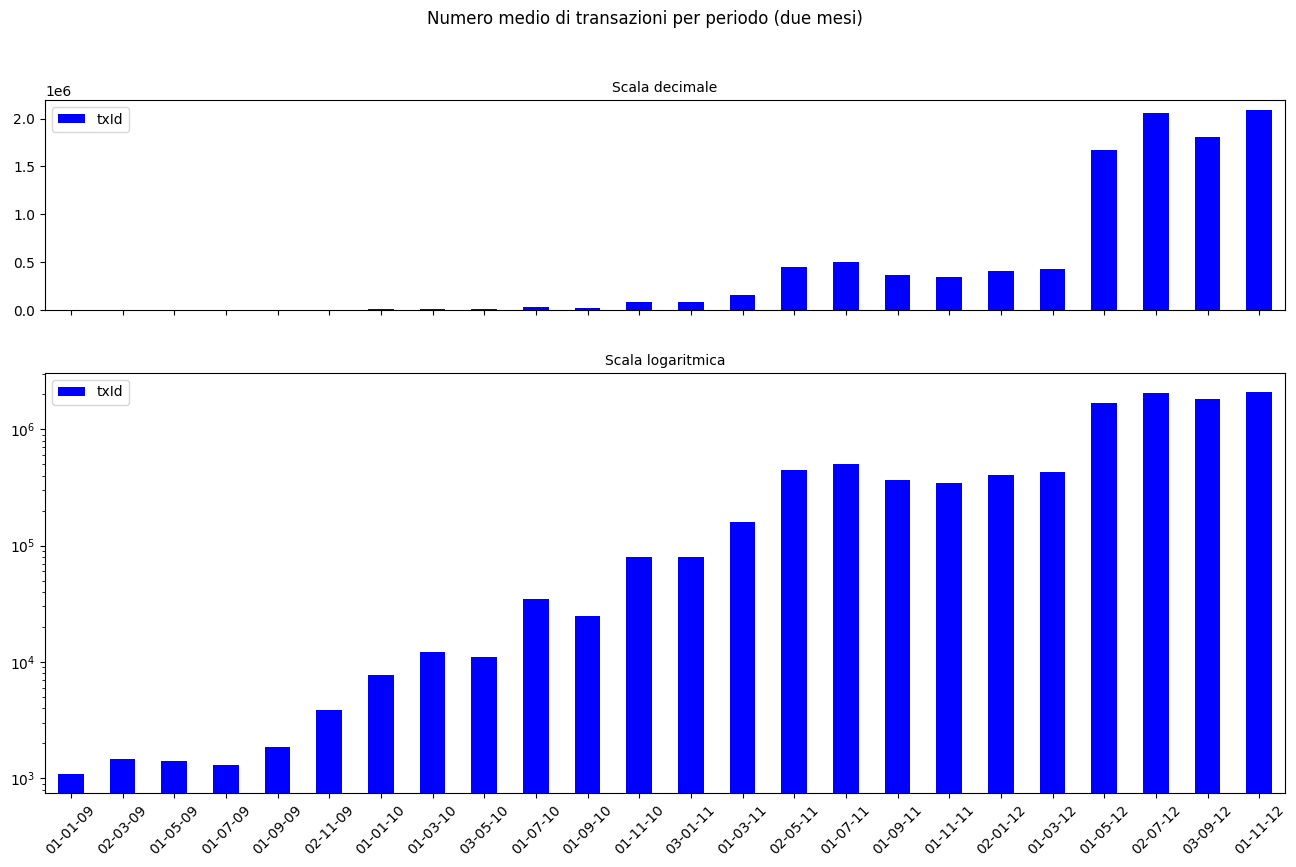

In [103]:
avg_transactions_per_period = transactions.loc[:,["timestamp", 'txId']].resample(
    '2BMS', on="timestamp").count()

avg_transactions_per_period.index = [date.strftime("%d-%m-%y") for date in avg_transactions_per_period.index]

fig, [ax1, ax2] = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(16, 9), gridspec_kw={'height_ratios': [1, 2]})
fig.suptitle("Numero medio di transazioni per periodo (due mesi)")

avg_transactions_per_period.plot(ax=ax1, kind="bar", color="blue")
ax1.set_title("Scala decimale", fontsize=10)

avg_transactions_per_period.plot(ax=ax2, kind="bar", color="blue")
ax2.set_title("Scala logaritmica", fontsize=10)
ax2.set_yscale("log")

plt.xticks(rotation=45)

plt.show()

### III. Ammontare totale degli UTXO al momento dell’ultima transazione

In [110]:
# output che sono stati input di una transazione
temp = outputs.merge(inputs, how='inner', left_on=["txId", "position"], right_on=["prevTxId", "prevTxPos"])
utxo = outputs.amount.sum() - temp.amount.sum()
print(utxo)  #  859303372614879

859303372614879


### IV. Distribuzione degli intervalli di tempo che intercorrono tra la transazione che genera un valore in output e quella che lo consuma

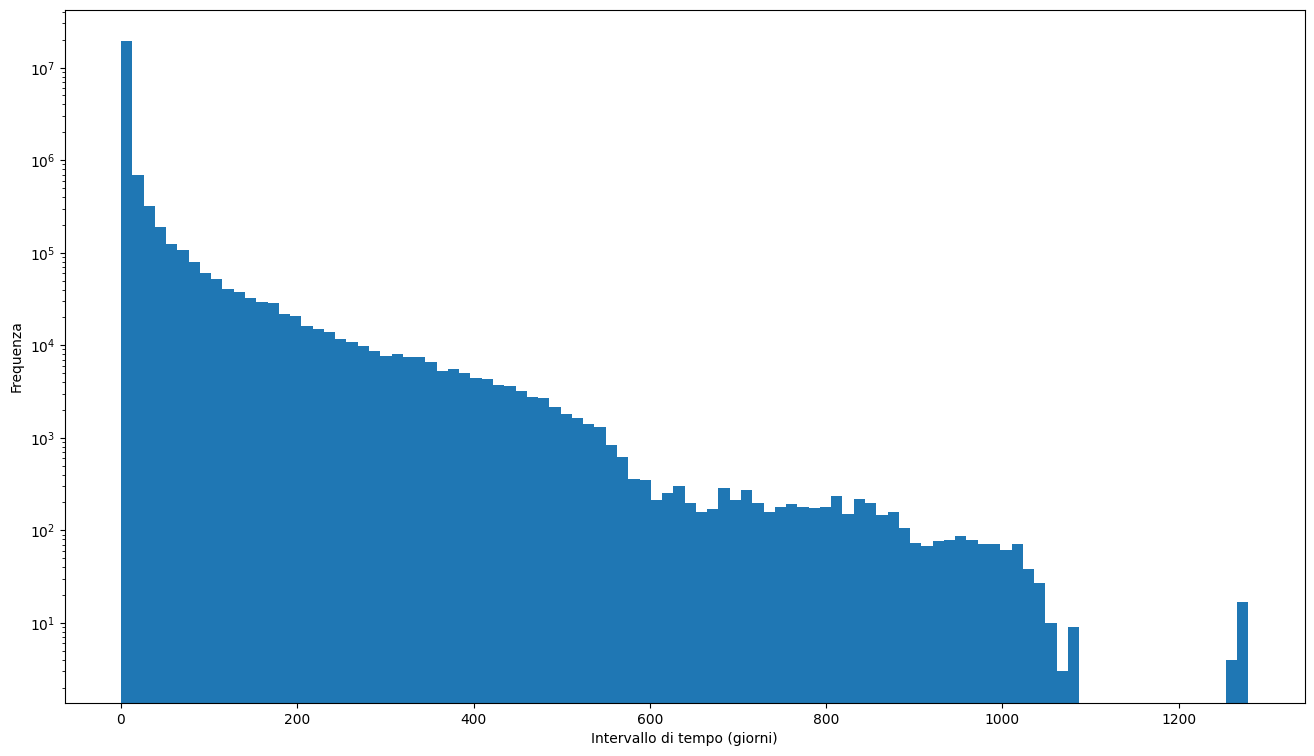

In [288]:
spent = transactions.merge(inputs, on="txId").rename(columns={"timestamp": "timestamp_spent"}).loc[:,["timestamp_spent", "txId", "prevTxId", "prevTxPos"]]
created = transactions.merge(outputs, on="txId").rename(columns={"timestamp": "timestamp_created"}).loc[:,["timestamp_created", "txId", "position"]]

diff = spent.merge(created.rename(columns={"txId": "outTxId"}), 
                   how="inner", left_on=["prevTxId", "prevTxPos"], 
                   right_on=["outTxId", "position"]).loc[:,["timestamp_created", "timestamp_spent"]]

diff["timestamp_difference"] = (diff.timestamp_spent - diff.timestamp_created).dt.days
diff.drop(diff[diff.timestamp_difference < 0].index, inplace=True) # rimuovo inconsistenze

plt.figure(figsize=(16, 9))
plt.hist(diff[["timestamp_difference"]], bins=100)
plt.yscale("log")
plt.xlabel("Intervallo di tempo (giorni)")
plt.ylabel("Frequenza")
plt.show()

### V. Evoluzione dei 3 address più ricchi (UTXO)

In [298]:
temp = (~outputs["txId"].isin(inputs["prevTxId"]))
utxo = outputs.loc[temp].loc[:,["addressId", "amount", "txId"]]
utxo_address = utxo.groupby(by="addressId").sum("amount").sort_values(by="amount", ascending=False).loc[:,["amount"]]
top_3_utxo = utxo_address.head(3).merge(mapping_df, how="inner", left_index=True, right_on="addressId").drop(columns=["addressId"])

address1, address2, address3 = top_3_utxo.index
print(top_3_utxo)


                amount                                hash
2770941  4972966980000  13vJZKHKBirruXwmjMaRtakzPQRRHQit1S
1083446  4716866106997  1933phfhK3ZgFQNLGSDXvqCn32k2buXY8a
6755311  4000000000000  1BqcwhKevdBKeos72b8E32Swjrp4iDVnjP


In [295]:
utxo_address1 = utxo.loc[utxo.addressId == address1].merge(transactions, on="txId").loc[:, ["addressId", "amount", "timestamp"]]
utxo_address2 = utxo.loc[utxo.addressId == address2].merge(transactions, on="txId").loc[:, ["addressId", "amount", "timestamp"]]
utxo_address3 = utxo.loc[utxo.addressId == address3].merge(transactions, on="txId").loc[:, ["addressId", "amount", "timestamp"]]

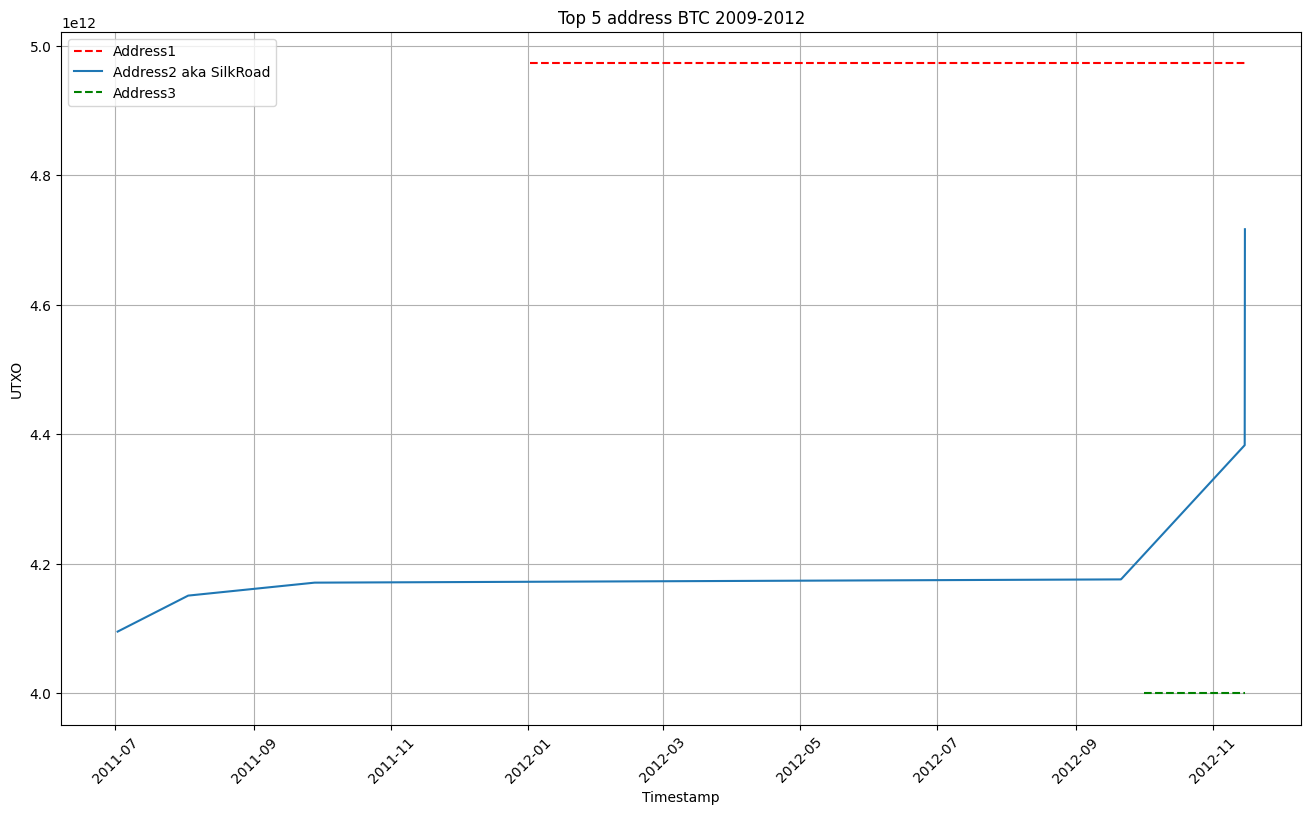

In [275]:
df_silkRoad = pd.DataFrame()
df_silkRoad.index = utxo_address2.timestamp
df_silkRoad["utxo"] = 0

for date in df_silkRoad.index:
    df_silkRoad.at[date, "utxo"] = utxo_address2.loc[utxo_address2["timestamp"] <= date].amount.sum()

timestamp_max = max(utxo_address1.timestamp.max(),
                    utxo_address2.timestamp.max(),
                    utxo_address3.timestamp.max())

plt.figure(figsize=(16, 9))

plt.hlines(y=top_3_utxo.loc[address1].amount,color='r', linestyle='--', label='Address1', xmin=utxo_address1.timestamp, xmax=timestamp_max)

plt.plot(df_silkRoad.index, df_silkRoad['utxo'], label="Address2 aka SilkRoad")
plt.hlines(y=df_silkRoad.loc[max(df_silkRoad.index)], xmin=max(df_silkRoad.index), xmax=timestamp_max)

plt.hlines(y=top_3_utxo.loc[address3].amount, color='g', linestyle='--', label='Address3', xmin=utxo_address3.timestamp, xmax=timestamp_max)

plt.xlabel('Timestamp')
plt.ylabel('UTXO')
plt.title('Top 5 address BTC 2009-2012')
plt.xticks(rotation=45)
plt.grid()
plt.legend(loc="upper left")

plt.show()

## 2. Clusterizzazione degli indirizzi di Bitcoin: euristica multi-input

In [51]:
# considerare transazioni con input > 1
inputs_transaction = inputs.merge(transactions, on="txId", how="inner").loc[:, ['txId', 'prevTxId', 'prevTxPos']]
tmp = inputs_transaction.groupby("txId")["prevTxId"].count() # index == txId's

# associare allo stesso utente tutti gli addressId utilizzati nell'input della stessa transazione
multi_inputs_transaction = (inputs_transaction.loc[inputs_transaction["txId"].isin(tmp.loc[tmp.values > 1].index)])
multi_inputs_transaction = multi_inputs_transaction.merge(outputs, left_on=["prevTxId", "prevTxPos"], right_on=["txId", "position"])
multi_inputs_transaction = multi_inputs_transaction.loc[:, ['txId_x', 'addressId']].rename(columns={"txId_x": "txId"}).set_index("addressId")
print(multi_inputs_transaction)

               txId
addressId          
367             504
192             504
255             504
555             557
533             557
...             ...
8707915    10572820
8707915    10572820
8707915    10572820
3524243    10572826
6137717    10572826

[14120915 rows x 1 columns]


In [52]:
# crea mapping (transazione: [indirizzi])
multi_inputs_dict = multi_inputs_transaction.groupby("txId").groups
print(multi_inputs_dict)

{504: [367, 192, 255], 557: [555, 533], 558: [557, 555], 559: [557, 557], 600: [275, 424, 438, 449, 457], 724: [509, 514], 746: [517, 364], 962: [610, 755, 788], 1075: [472, 480, 638, 573, 529, 500, 446, 773, 844, 840], 1077: [414, 680, 336, 550, 746, 830], 1206: [1009, 440, 604, 401, 789, 951, 966, 976], 1236: [901, 764], 1320: [327, 956, 1114, 468, 1143, 825, 1016, 1157, 962, 783], 1414: [1003, 943, 837], 1480: [621, 1316, 1260, 1211, 1319, 1353], 1613: [1015, 1289, 1154, 1132, 939, 1048, 1225, 866, 1001, 1153], 1974: [1162, 1137, 1534, 1541, 1643, 1597, 1600, 1613, 1757, 1735, 1742, 1765, 1362, 1403, 1420, 1419, 1417, 1418, 1411, 1620], 1997: [1738, 1790, 1681], 2308: [2132, 2140, 1927, 1923, 2102, 1849, 1859, 1961, 2151, 2178, 2020, 2062], 2550: [1492, 665, 1253, 835, 1059, 885, 1214, 1636, 983, 819, 1171, 1081, 1396, 858, 699, 426, 1546, 537, 1336, 768], 2649: [2509, 2483], 2863: [2840, 2840], 2864: [2840, 2840], 3358: [2411, 2109, 1939, 1946, 2566, 1990, 2513, 2542, 2055, 2321, 2

In [104]:
graph = nx.DiGraph()
graph.add_nodes_from(mapping_df["addressId"])

for addressIds in multi_inputs_dict.values():
    first_node = addressIds[0]
    for address in addressIds[1:]:
        if address != first_node:
            graph.add_edge(first_node, address)
nx.freeze(graph)

wcc = list(nx.weakly_connected_components(graph)) # lista di set di addressId

In [54]:
if len(list(nx.nodes_with_selfloops(graph))) != 0:
    print("> Error... trovato self loop con primo address")

# La classe DiGraph garantisce l'assenza di archi ripetuti.
# A prova di ciò:
for addressIds in multi_inputs_dict.values():
    first_node = addressIds[0]
    for address in addressIds[1:]:
        if graph.number_of_edges(first_node, address) > 1:
            print("> Error... trovato arco ripetuto")
            break

In [97]:
cluster_dim = [len(c) for c in wcc]
max_cluster = max(wcc, key=len)
mean_cluster = sum(cluster_dim)/len(cluster_dim)
min_cluster = min(wcc, key=len)
number_of_singlets = sum(1 for c in wcc if len(c) == 1)

print(f'{len(cluster_dim):9,} - #cluster')
print(f'{len(max_cluster):9,} - #cluster più grande')
print(f'{len(min_cluster):9} - #cluster più piccolo')
print(f'{mean_cluster:9.2f} - Dimensione media dei cluster')
print(f'{number_of_singlets:9,} - Numero di "singoletti"')

4,800,614 - #cluster
  259,773 - #cluster più grande
        1 - #cluster più piccolo
     1.81 - Dimensione media dei cluster
4,302,594 - Numero di "singoletti"


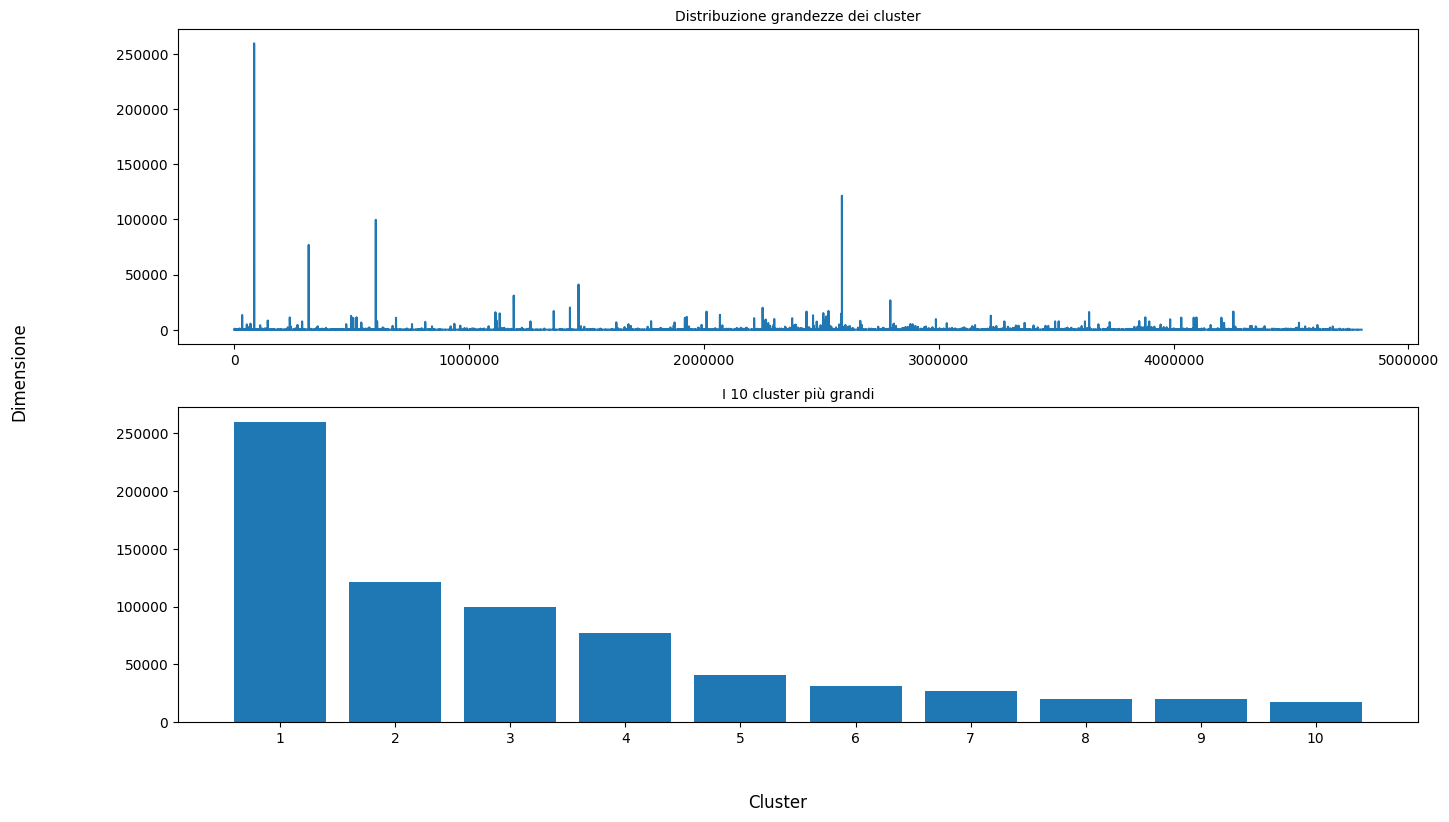

In [137]:
import heapq

biggest_clusters = heapq.nlargest(10, wcc, key=len)

fig, [ax1, ax2] = plt.subplots(nrows=2, ncols=1, figsize=(16, 9))
fig.supxlabel('Cluster')
fig.supylabel('Dimensione')

ax1.set_title("Distribuzione grandezze dei cluster", fontsize=10)
ax1.ticklabel_format(useOffset=False, style="plain")
ax1.plot(cluster_dim)

ax2.set_title("I 10 cluster più grandi", fontsize=10)
xticks = range(1,11,1)
ax2.bar(x=xticks, height=[len(c) for c in biggest_clusters], tick_label=xticks)

plt.show()

## 3. Deanonimizzazione degli indirizzi

In [140]:
# biggest_clusters contiene già i 10 cluster con più indirizzi

from selenium import webdriver
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.common.by import By
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException

driver = webdriver.Chrome()
proxies = open("./proxies.txt", "r").readlines()
print(proxies)

['106.240.89.60:4145\n', '184.181.217.201:4145\n', '70.166.167.55:57745\n', '200.80.227.234:4145\n', '98.162.25.29:31679\n', '46.29.229.77:4145\n', '84.238.250.37:10801\n', '123.234.46.51:4153\n', '181.174.85.78:5678\n', '114.88.103.45:4145\n', '67.201.33.10:25283\n', '31.146.97.254:5678\n', '103.210.29.113:31433\n', '103.87.81.86:5678\n', '115.164.146.10:5678\n', '208.102.51.6:58208\n', '173.212.253.25:16529\n', '123.60.139.197:20000\n', '87.121.77.66:4145\n', '81.16.1.71:5678\n', '123.60.139.197:8282\n', '83.220.46.106:4145\n', '205.240.77.164:4145\n', '27.147.155.70:52596\n', '39.104.89.111:9000\n', '51.158.124.167:16379\n', '103.105.103.1:3629\n', '104.192.202.11:1080\n', '103.117.110.1:4153\n', '110.78.82.70:5678\n', '123.60.139.197:8090\n', '150.129.109.14:5678\n', '195.114.9.184:34445\n', '181.143.21.146:4153\n', '222.165.223.139:41541\n', '104.37.135.145:4145\n', '103.134.214.130:1648\n', '179.96.251.161:5678\n', '84.16.10.110:4145\n', '46.227.36.152:1080\n', '202.58.199.229:56